<a href="https://colab.research.google.com/github/AdrianGuel/AdrianGuel.github.io/blob/main/Copia_de_stochasticsimulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!cd /content/drive/MyDrive/SDE-Sim

In [10]:
!python /content/drive/MyDrive/SDE-Sim/SDE_Sim.py

Starting Simulation...
<==================================================> dt: 1.05e-03 acc: 4591 rej: 282 ETA: -0s
Simulation Finished: 6.00s
Saving Parameters...
Total Time: 6.07s


In [ ]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import time
import json

%matplotlib inline

In [ ]:
def interp_deriv(x, t, p, smooth = '0D', polyorder_x = 5, window_length_x = 51, grid_size = 600):
    x = cp.array(x)
    min_val = cp.min(x)
    max_val = cp.max(x)
    dt = cp.array(t[1:]-t[:-1])
    bins = cp.linspace(min_val, max_val, grid_size)
    
    if smooth == '1D':
        p_savgol = savgol_filter(p, window_length = window_length_x, polyorder = polyorder_x, axis = -1, mode = 'constant', cval = 0.0)
        p = cp.array(p_savgol)
    elif smooth == '2D':
        pass
    else:
        p = cp.array(p)
    #Following step too slow with numpy, hence using cupy    
    p_interp = cp.array([cp.interp(bins, x[i], p[i], left=0, right=0) for i in range(p.shape[0])])
    dp_dt = (p_interp[1:] - p_interp[0:-1])/dt[:,None]
    
    return (bins.get(), p_interp.get(), dp_dt.get())

def gamma_sq_t(dq_dt, dx):
    return np.sum(dq_dt**2, axis=-1)*dx

def info_length(gamma_sq, t):
    return np.cumsum(np.sqrt(gamma_sq)*(t[1:]-t[:-1]), axis=0)

In [ ]:
input_directory = 'data/'
x = np.load(input_directory+'x.npy')
p = np.load(input_directory+'p_x.npy')
t = np.load(input_directory+'t.npy')
with open(input_directory + 'parameters.txt', 'r') as file:
    params = json.load(file)
#dt = params['dt']
#grid_size = params['grid_size']
t_init = params['t_init']
t_end = params['t_end']

In [ ]:
#p(x) = q(x)^2
bins, q_0, deriv_0 = interp_deriv(x, t, np.sqrt(p), smooth = '0D')
_, q_1, deriv_1 = interp_deriv(x, t, np.sqrt(p), smooth = '1D')
_, q_2, deriv_2 = interp_deriv(x, t, np.sqrt(p), smooth = '1D', polyorder_x = 5, window_length_x = 21)
dx = bins[1]-bins[0]

mean_0 = np.sum(q_0**2*bins[None,:], axis=-1)*dx
mean_1 = np.sum(q_1**2*bins[None,:], axis=-1)*dx
mean_2 = np.sum(q_2**2*bins[None,:], axis=-1)*dx
var_0= np.sum(q_0**2*bins[None,:]**2, axis=-1)*dx - mean_0**2
var_1 = np.sum(q_1**2*bins[None,:]**2, axis=-1)*dx - mean_1**2
var_2 = np.sum(q_2**2*bins[None,:]**2, axis=-1)*dx - mean_2**2

ga_0 = gamma_sq_t(deriv_0, dx)
ga_1 = gamma_sq_t(deriv_1, dx)
ga_2 = gamma_sq_t(deriv_2, dx)
il_0 = info_length(ga_0, t)
il_1 = info_length(ga_1, t)
il_2 = info_length(ga_2, t)

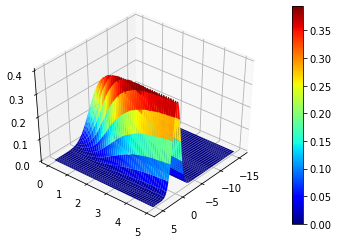

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(*np.meshgrid(bins, t[::10]), q_1[::10]**2, cmap='jet')
#ax.set_zlim(0,0.05)
fig.colorbar(surf)
ax.view_init(40,40)
plt.show()